# Importing Libraries

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from persiantools.jdatetime import JalaliDate
from mpl_toolkits.basemap import Basemap

# Data Preparation

## Loading Datasets

In [248]:
geography = pd.read_csv(f"Dataset/Geography Information.csv")
geography['city'] = geography['city'].str.strip()
print(geography)

    latitude  longitude  elevation          city
0  35.676624  51.428570     1183.0        Tehran
1  38.066784  46.150738     1399.0        Tabriz
2  36.309315  59.648438      986.0       Mashhad
3  32.653778  51.695120     1579.0       Isfahan
4  29.630930  52.560837     1541.0        Shiraz
5  31.318100  48.700836       23.0         Ahvaz
6  37.293495  49.535810        4.0         Rasht
7  30.263618  57.119434     1762.0        Kerman
8  27.170473  56.224940        9.0  Bandar Abbas
9  35.817223  50.980644     1341.0         Karaj


In [249]:
# City name lists
cities = [
    "Tehran",
    "Tabriz",
    "Mashhad",
    "Isfahan",
    "Shiraz",
    "Ahvaz",
    "Rasht",
    "Kerman",
    "Bandar Abbas",
    "Karaj"
]

# list to keep dataframes
dataframes = []

# Reading DataFrames and Saving them in a dictionary
for city in cities:
    df = pd.read_csv(f"Dataset/{city}.csv")
    df['city'] = city
    dataframes.append(df)

### Dataset Combining 

In [250]:
## Data Cleaning 
df_combined = pd.concat(dataframes, ignore_index=True)
df_combined = pd.merge(df_combined, geography, on='city', how='left')

# Save the combined dataframe to a new CSV file
df_combined.to_csv("Dataset/Combined Dataset.csv", index=False)

## Data Cleaning 

In [251]:
del df, df_combined, dataframes, geography, cities
df = pd.read_csv("Dataset/Combined Dataset.csv")

### Checking NaNs 

In [252]:
print("Dataset Missing Values:")
missing_values = df.isnull().sum()
print(missing_values)

Dataset Missing Values:
time                               0
temp_max (°C)                      0
temp_min (°C)                      0
temp_mean (°C)                     0
daylight_duration (s)              0
precipitation_sum (mm)             0
rain_sum (mm)                      0
snowfall_sum (cm)                  0
precipitation_hours (h)            0
wind_speed_max (km/h)              0
wind_gusts_max (km/h)              0
wind_direction_dominant (°)        0
shortwave_radiation_sum (MJ/m²)    0
evapotranspiration (mm)            0
city                               0
latitude                           0
longitude                          0
elevation                          0
dtype: int64


### Gregorian and Jalali Date Settings 

In [253]:
df["time"] = pd.to_datetime(df["time"])

In [254]:
# create Jalali date column
df["date_jalali"] = df["time"].apply(lambda time: JalaliDate(time)) 

# rename time to date_gregorian
df.rename(columns={'time': 'date_gregorian'}, inplace=True)

In [255]:

df["year"] = df["date_jalali"].apply(lambda date: date.year)
df["month"] = df["date_jalali"].apply(lambda date: date.month)
df["season"] = df["month"].apply(lambda month:
                                    "Spring" if month in [1, 2, 3] else 
                                    "Summer" if month in [4, 5, 6] else 
                                    "Autumn" if month in [7, 8, 9] else 
                                    "Winter")
df['month'] = df['month'].map({
    1: "Farvardin",
    2: "Ordibehesht",
    3: "Khordad",
    4: "Tir",
    5: "Mordad",
    6: "Shahrivar",
    7: "Mehr",
    8: "Aban",
    9: "Azar",
    10: "Dey",
    11: "Bahman",
    12: "Esfand"
})                       

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49260 entries, 0 to 49259
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_gregorian                   49260 non-null  datetime64[ns]
 1   temp_max (°C)                    49260 non-null  float64       
 2   temp_min (°C)                    49260 non-null  float64       
 3   temp_mean (°C)                   49260 non-null  float64       
 4   daylight_duration (s)            49260 non-null  float64       
 5   precipitation_sum (mm)           49260 non-null  float64       
 6   rain_sum (mm)                    49260 non-null  float64       
 7   snowfall_sum (cm)                49260 non-null  float64       
 8   precipitation_hours (h)          49260 non-null  float64       
 9   wind_speed_max (km/h)            49260 non-null  float64       
 10  wind_gusts_max (km/h)            49260 non-null  float64  

### Memory Cleaning 

In [257]:
def datatype_cleaner(df):
    
    for column in df.select_dtypes(include=['float', 'int']).columns:
        min_val = df[column].min()
        max_val = df[column].max()
    
        col_dtype = df[column].dtype
    
        # Check ranges for int and float types
        if np.issubdtype(col_dtype, np.floating):
            if min_val >= -65504 and max_val <= 65504:  # float16
                df[column] = df[column].astype(np.float16)
            elif min_val >= -3.4e38 and max_val <= 3.4e38:  # float32
                df[column] = df[column].astype(np.float32)
            else:
                df[column] = df[column].astype(np.float64)
    
        elif np.issubdtype(col_dtype, np.integer):
            if min_val >= -128 and max_val <= 127:  # int8
                df[column] = df[column].astype(np.int8)
            elif min_val >= -32768 and max_val <= 32767:  # int16
                df[column] = df[column].astype(np.int16)
            elif min_val >= -2147483648 and max_val <= 2147483647:  # int32
                df[column] = df[column].astype(np.int32)
            else:
                df[column] = df[column].astype(np.int64)

In [258]:
# calling the function to clean datatype memory usage
datatype_cleaner(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49260 entries, 0 to 49259
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_gregorian                   49260 non-null  datetime64[ns]
 1   temp_max (°C)                    49260 non-null  float16       
 2   temp_min (°C)                    49260 non-null  float16       
 3   temp_mean (°C)                   49260 non-null  float16       
 4   daylight_duration (s)            49260 non-null  float16       
 5   precipitation_sum (mm)           49260 non-null  float16       
 6   rain_sum (mm)                    49260 non-null  float16       
 7   snowfall_sum (cm)                49260 non-null  float16       
 8   precipitation_hours (h)          49260 non-null  float16       
 9   wind_speed_max (km/h)            49260 non-null  float16       
 10  wind_gusts_max (km/h)            49260 non-null  float16  

In [259]:
df.to_csv("Final Dataset.csv", index=False)

# Data Visualization

## Weather Analysis

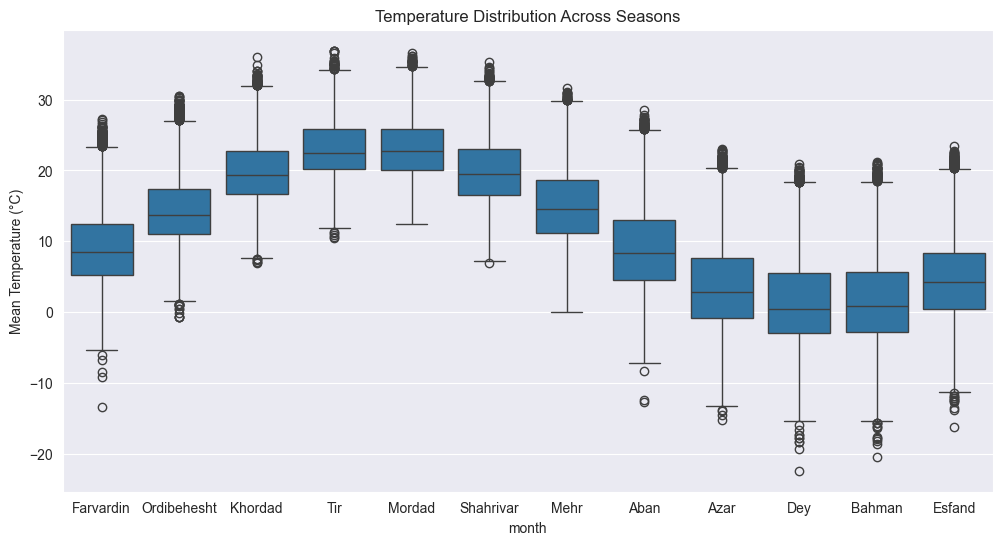

In [263]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp_min (°C)', data=df)
plt.title("Temperature Distribution Across Seasons")
plt.ylabel("Mean Temperature (°C)")
plt.show()

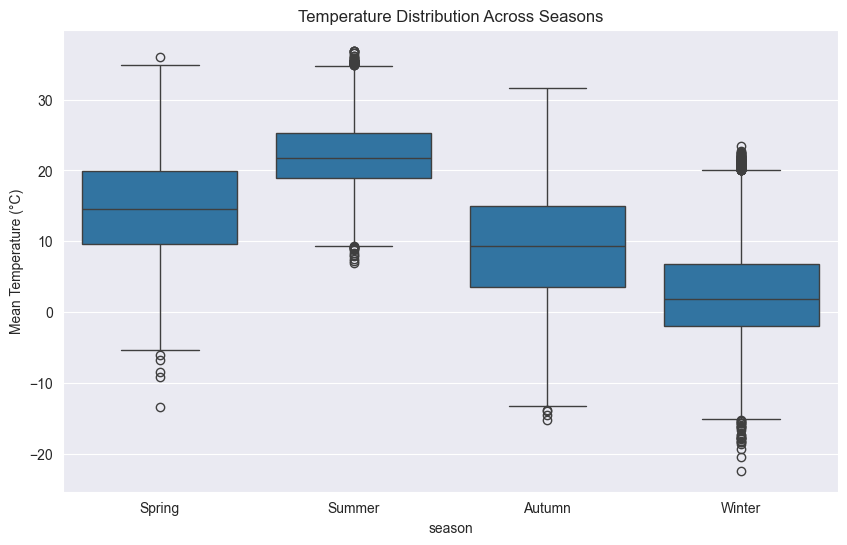

In [261]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='temp_min (°C)', data=df)
plt.title("Temperature Distribution Across Seasons")
plt.ylabel("Mean Temperature (°C)")
plt.show()

In [ ]:
city_trends = df.groupby('city').agg({
    'temp_mean (°C)': 'mean',
    'precipitation_sum (mm)': 'mean',
    'wind_speed_max (km/h)': 'mean'
})
city_trends.plot(kind='bar', subplots=True, figsize=(10, 8), title="City-wise Weather Trends")